# day06: Elastic Net with Scikit Learn

# Objectives

* See how we can use sklearn's builtin functionality for quickly implementing hyperparameter sweeps
* Explore how the ElasticNet regression model is implemented

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Dataset

We'll use one of sklearn's builting datasets, which tries to predict diabetes progression in a set of patients from a number of biomarkers. 

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [142]:
import sklearn.datasets
import sklearn.model_selection

In [143]:
seed = 1852
diabetes = sklearn.datasets.load_diabetes(as_frame = True, scaled = True)

df_all = diabetes['frame']

# We can call train_test_split on numpy arrays or on pandas dataframes, they both work
df_train_val, df_test = sklearn.model_selection.train_test_split(df_all, test_size=0.2, random_state = seed)
df_train_val.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,0.000382,0.001534,0.000349,0.001114,-0.000014,-0.000188,-0.000395,0.000049,0.000570,0.000495,151.002833
std,0.046436,0.047705,0.048276,0.047361,0.046116,0.045025,0.047055,0.045835,0.047989,0.045906,76.577594
min,-0.107226,-0.044642,-0.089197,-0.108956,-0.126781,-0.115613,-0.102307,-0.076395,-0.126097,-0.137767,25.000000
25%,-0.034575,-0.044642,-0.034229,-0.033213,-0.031840,-0.027618,-0.036038,-0.039493,-0.033246,-0.030072,88.000000
50%,0.005383,-0.044642,-0.008362,-0.005670,-0.002945,-0.001627,-0.006584,-0.002592,-0.003301,0.003064,138.000000
75%,0.038076,0.050680,0.030440,0.035644,0.027326,0.028435,0.030232,0.034309,0.032432,0.027917,208.000000
max,0.110727,0.050680,0.170555,0.125158,0.133274,0.131461,0.181179,0.155345,0.133597,0.135612,346.000000


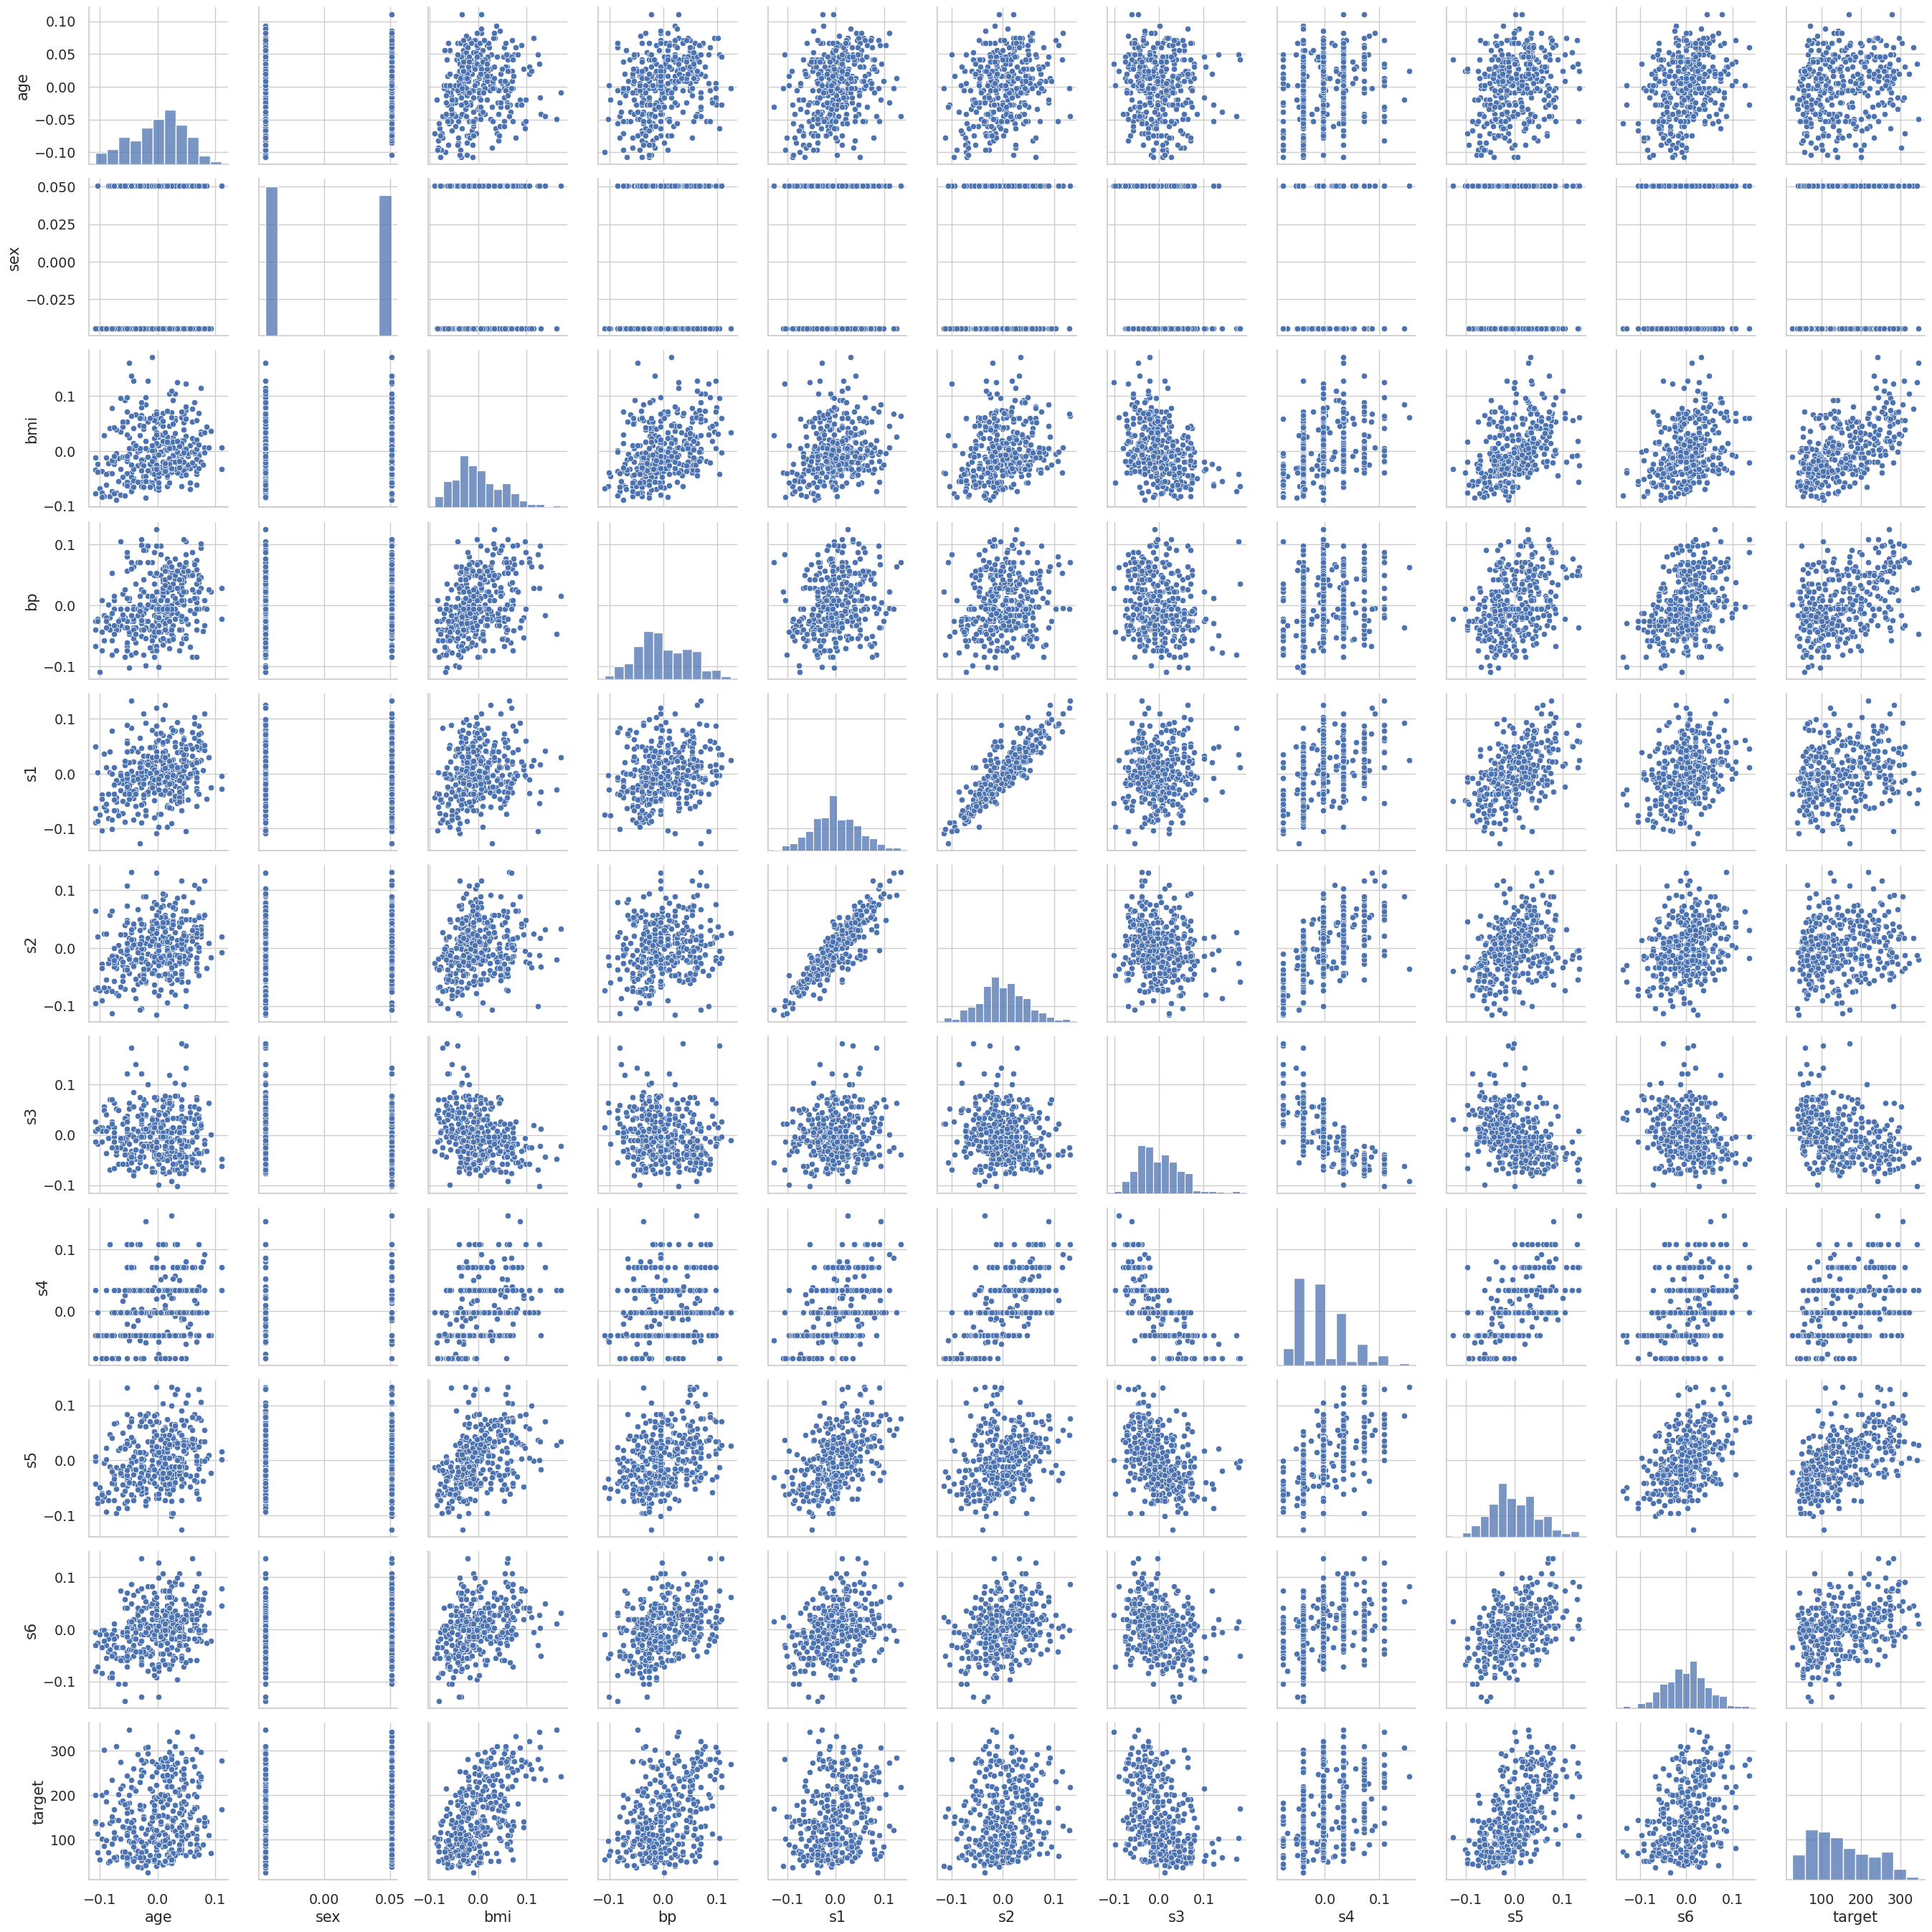

In [144]:
sns.pairplot(df_train_val)
#sns.pairplot(df_train_val.iloc[:,3:])

## Making our pipeline

Let's use the `ElasticNet` classifier included in scikit-learn, which combines L1 and L2 regularization. It uses 2 hyparameters to control the strengths of the L1 and L2 terms, `alpha` and `l1_ratio`, is a slightly unintuitive way.

[(from the documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

```
1 / (2 * n_samples) * ||y - Xw||^2_2
+ alpha * l1_ratio * ||w||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
```

In other words, `alpha` controls the overall regularization strength and `l1_ratio` controls the relative strength between the L1 and L2 terms. If `l1_ratio` is 0, then the model is a pure ridge regression, and if `l1_ratio` is 1, then the model is a pure lasso regression.

In [145]:
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.metrics
import sklearn.model_selection

Let's define the grid of hyparameters we want to search and make our datasets from the dataframe.

In [146]:
alpha_grid = [0.01, 0.1, 1, 10]
l1_ratio_grid = np.linspace(0.1, 0.9, num=3)
deg_grid = [1, 2]

N = len(df_train_val)
x_train_val = df_train_val.iloc[:,:-1].to_numpy()
y_train_val = df_train_val.iloc[:,-1].to_numpy()
y_train_val = np.reshape(y_train_val, (N, 1))
x_test = df_test.iloc[:,:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

### KFold Split

First, instead of making the data split for CV ourselves, we can use the `KFold` function to calculate it for us. We can store our results in a dataframe for easy plotting. 

In [147]:
n_folds = 5
perf_dict = {"degree":[], "alpha":[], "l1_ratio":[], "mse":[]}
kf = sklearn.model_selection.KFold(n_splits=n_folds)
for alpha in alpha_grid:
    for l1_ratio in l1_ratio_grid:
        for deg in deg_grid:
            enet_pipeline = sklearn.pipeline.Pipeline([
                    ('rescale', sklearn.preprocessing.MinMaxScaler()),
                    ("preproccessing", sklearn.preprocessing.PolynomialFeatures(deg, include_bias=False)),
                    ("regr", sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)),
                    ])
            mse_folds = []
            for train_ind, val_ind in kf.split(x_train_val):
                x_train, x_val = x_train_val[train_ind], x_train_val[val_ind]
                y_train, y_val = y_train_val[train_ind], y_train_val[val_ind]
                enet_pipeline.fit(x_train, y_train)
                yhat = enet_pipeline.predict(x_val)
                mse = sklearn.metrics.mean_squared_error(y_val, yhat)
                mse_folds.append(mse)
            perf_dict["degree"].append(deg)
            perf_dict["alpha"].append(alpha)
            perf_dict["l1_ratio"].append(l1_ratio)
            perf_dict["mse"].append(np.mean(mse_folds))

In [148]:
perf_df = pd.DataFrame(perf_dict)
perf_df

,degree,alpha,l1_ratio,mse
0,1,0.01,0.1,3014.372710
1,2,0.01,0.1,2939.992954
2,1,0.01,0.5,2993.567254
3,2,0.01,0.5,2942.453559
4,1,0.01,0.9,2986.954252
5,2,0.01,0.9,2984.219026
6,1,0.10,0.1,3773.187376
7,2,0.10,0.1,3107.560798
8,1,0.10,0.5,3428.676044
9,2,0.10,0.5,3014.345513


<Axes: xlabel='degree', ylabel='mse'>

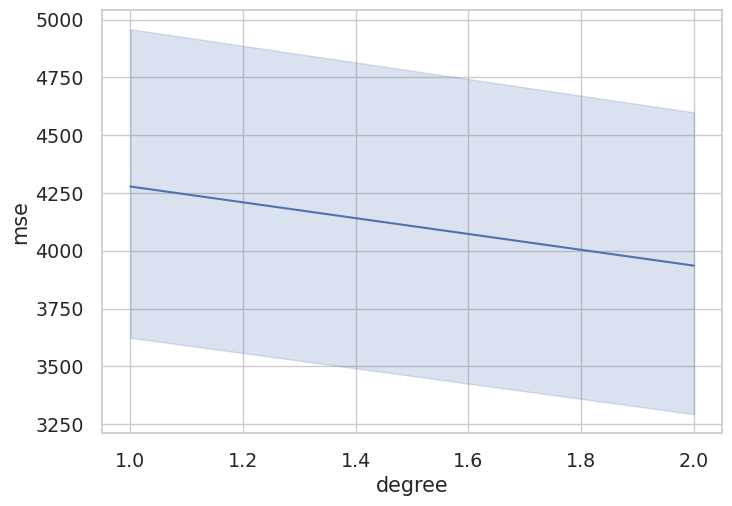

In [130]:
sns.lineplot(perf_df, x="degree", y="mse")

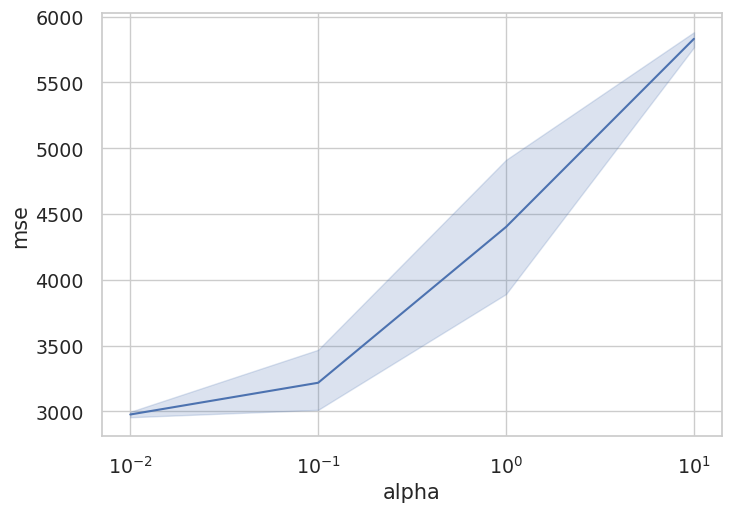

In [131]:
sns.lineplot(perf_df, x="alpha", y="mse")
plt.xscale('log')

<Axes: xlabel='l1_ratio', ylabel='mse'>

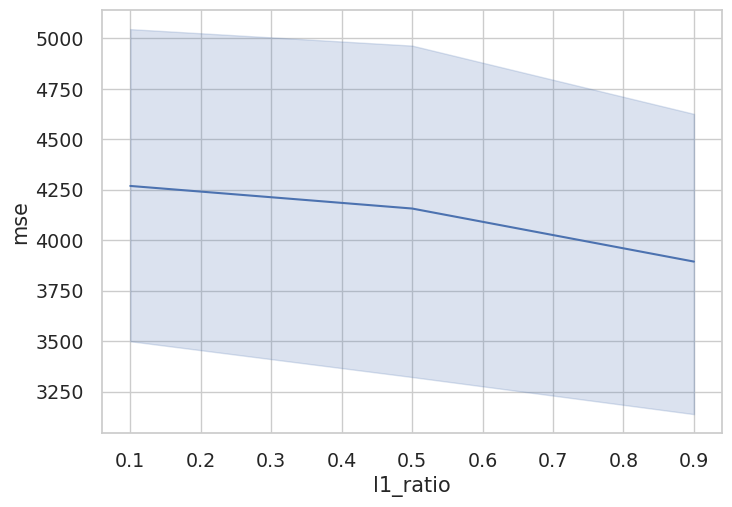

In [132]:
sns.lineplot(perf_df, x="l1_ratio", y="mse")

It looks like we want a higher l1_ratio. However, we should look at the full data distribution. Seaborn's builtin error bars can obscur outliers.

<Axes: xlabel='l1_ratio', ylabel='mse'>

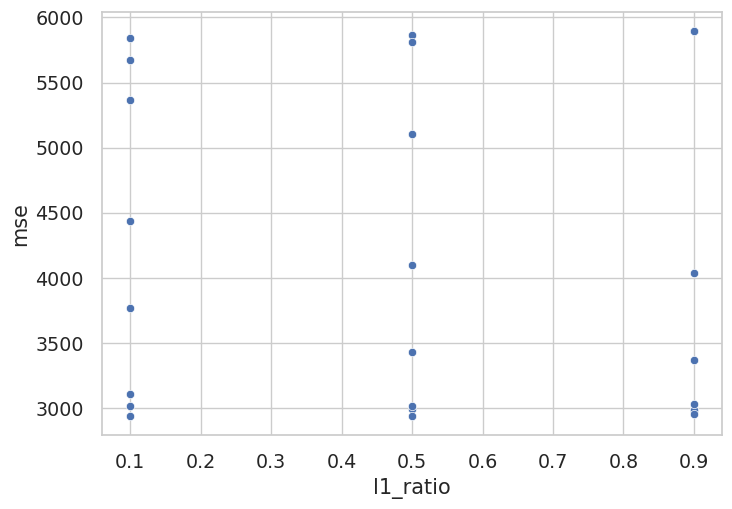

In [160]:
sns.scatterplot(perf_df, x="l1_ratio", y="mse")

In [133]:
perf_df.sort_values(by="mse")

,degree,alpha,l1_ratio,mse
1,2,0.01,0.1,2939.992954
3,2,0.01,0.5,2942.453559
11,2,0.10,0.9,2952.767897
5,2,0.01,0.9,2984.219026
4,1,0.01,0.9,2986.954252
2,1,0.01,0.5,2993.567254
9,2,0.10,0.5,3014.345513
0,1,0.01,0.1,3014.372710
10,1,0.10,0.9,3031.455614
7,2,0.10,0.1,3107.560798


## Using `cross_val_score`

We can actually skip a lot of what we just implemented. The `cross_val_score` function will run cross validation on a set number of folds for us, and calculate a given result. Note that we use **negative** mean squared error for scoring. Scikit-learn wants a score that can be maximized, not minimized. 

In [159]:
perf_dict = {"degree":[], "alpha":[], "l1_ratio":[], "mse":[]}
for alpha in alpha_grid:
    for l1_ratio in l1_ratio_grid:
        for deg in deg_grid:
            enet_pipeline = sklearn.pipeline.Pipeline([
                    ('rescale', sklearn.preprocessing.MinMaxScaler()),
                    ("preproccessing", sklearn.preprocessing.PolynomialFeatures(deg, include_bias=False)),
                    ("regr", sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)),
                    ])
            mse = sklearn.model_selection.cross_val_score(enet_pipeline, 
                                                          x_train_val, y_train_val, 
                                                          cv=n_folds, 
                                                          scoring='neg_mean_squared_error') 
            perf_dict["degree"].append(deg)
            perf_dict["alpha"].append(alpha)
            perf_dict["l1_ratio"].append(l1_ratio)
            perf_dict["mse"].append(np.mean(mse))
perf_df.sort_values(by="mse")

,degree,alpha,l1_ratio,mse
1,2,0.01,0.1,2939.992954
3,2,0.01,0.5,2942.453559
11,2,0.10,0.9,2952.767897
5,2,0.01,0.9,2984.219026
4,1,0.01,0.9,2986.954252
2,1,0.01,0.5,2993.567254
9,2,0.10,0.5,3014.345513
0,1,0.01,0.1,3014.372710
10,1,0.10,0.9,3031.455614
7,2,0.10,0.1,3107.560798


## Using `GridSearchCV`

Finally, we can skip almost everything. Scikit-learn has a built in infrastructure which allows for quich hyperparameter sweeps. We can just define our bounds, and we'll automatically get a model trained on the best hyperparameters for the full training set. 

In [151]:
enet_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproccessing", sklearn.preprocessing.PolynomialFeatures(degree=deg, include_bias=False)),
        ("regr", sklearn.linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)),
        ])
param_grid = {
    'preproccessing__degree': deg_grid,
    'regr__alpha': alpha_grid,
    'regr__l1_ratio': l1_ratio_grid
    }

enet_grid = sklearn.model_selection.GridSearchCV(enet_pipeline, param_grid, n_jobs=-1, 
                      cv=5, scoring='neg_mean_squared_error')

In [152]:
enet_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', MinMaxScaler()),
                                       ('preproccessing',
                                        PolynomialFeatures(include_bias=False)),
                                       ('regr',
                                        ElasticNet(alpha=10, l1_ratio=0.9))]),
             n_jobs=-1,
             param_grid={'preproccessing__degree': [1, 2],
                         'regr__alpha': [0.01, 0.1, 1, 10],
                         'regr__l1_ratio': array([0.1, 0.5, 0.9])},
             scoring='neg_mean_squared_error')

In [153]:
enet_grid.fit(x_train_val, y_train_val)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rescale', MinMaxScaler()),
                                       ('preproccessing',
                                        PolynomialFeatures(include_bias=False)),
                                       ('regr',
                                        ElasticNet(alpha=10, l1_ratio=0.9))]),
             n_jobs=-1,
             param_grid={'preproccessing__degree': [1, 2],
                         'regr__alpha': [0.01, 0.1, 1, 10],
                         'regr__l1_ratio': array([0.1, 0.5, 0.9])},
             scoring='neg_mean_squared_error')

In [154]:
print(enet_grid.best_params_, enet_grid.best_score_)

{'preproccessing__degree': 2, 'regr__alpha': 0.01, 'regr__l1_ratio': 0.1} -2939.992954332466


In [155]:
enet_grid.score(x_test, y_test)

-3072.79594758758

Given that we're getting a low alpha value and l1_ratio, let's try out a normal linear regression and ridge regression as well. 

In [161]:
lin_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproccessing", sklearn.preprocessing.PolynomialFeatures(degree=deg, include_bias=False)),
        ("regr", sklearn.linear_model.LinearRegression()),
        ])
param_grid_lin = {
    'preproccessing__degree': deg_grid,
    }

lin_grid = sklearn.model_selection.GridSearchCV(lin_pipeline, param_grid_lin, n_jobs=-1, 
                      cv=5, scoring='neg_mean_squared_error')
lin_grid.fit(x_train_val, y_train_val)
print(lin_grid.best_params_, lin_grid.best_score_)
print(lin_grid.score(x_test, y_test))

{'preproccessing__degree': 1} -2987.357504477074
-3110.764860763206


In [162]:
ridge_pipeline = sklearn.pipeline.Pipeline([
        ('rescale', sklearn.preprocessing.MinMaxScaler()),
        ("preproccessing", sklearn.preprocessing.PolynomialFeatures(degree=deg, include_bias=False)),
        ("regr", sklearn.linear_model.Ridge(alpha=alpha)),
        ])
param_grid_ridge = {
    'preproccessing__degree': deg_grid,
    'regr__alpha': alpha_grid
    }

ridge_grid = sklearn.model_selection.GridSearchCV(ridge_pipeline, param_grid_ridge, n_jobs=-1, 
                      cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(x_train_val, y_train_val)
print(ridge_grid.best_params_, ridge_grid.best_score_)
print(ridge_grid.score(x_test, y_test))

{'preproccessing__degree': 2, 'regr__alpha': 1} -2948.588280233508
-3001.5817262192427
